# With Support Vector Machines

In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import joblib
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    return result

In [3]:
# Emotions in the RAVDESS dataset
emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Emotions to observe
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

In [4]:
# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob("./ravdess_data/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [5]:
# Split the dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [6]:
print("Training set shape:", x_train.shape)
print("Testing set shape:", x_test.shape)
print(f'Features extracted: {x_train.shape[1]}')

Training set shape: (576, 180)
Testing set shape: (192, 180)
Features extracted: 180


In [7]:
# Initialize the SVM Classifier
model = SVC(kernel='rbf', C=1.0, random_state=42)

In [8]:
# Train the model
print("Training the SVM model...")
model.fit(x_train, y_train)

Training the SVM model...


SVC(random_state=42)

In [9]:
# Predict for the test set
y_pred = model.predict(x_test)

In [10]:
# Calculate and print accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 45.83%


In [11]:
# Calculate precision, recall, and F1-score for each emotion
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=observed_emotions)

# Print precision, recall, and F1-score for each emotion
print("\nDetailed metrics for each emotion:")
for emotion, p, r, f1 in zip(observed_emotions, precision, recall, f1_score):
    print(f"{emotion}:")
    print(f"  Precision: {p:.2f}")
    print(f"  Recall: {r:.2f}")
    print(f"  F1-score: {f1:.2f}")


Detailed metrics for each emotion:
calm:
  Precision: 0.56
  Recall: 0.91
  F1-score: 0.69
happy:
  Precision: 0.30
  Recall: 0.12
  F1-score: 0.17
fearful:
  Precision: 0.38
  Recall: 0.42
  F1-score: 0.40
disgust:
  Precision: 0.43
  Recall: 0.42
  F1-score: 0.43


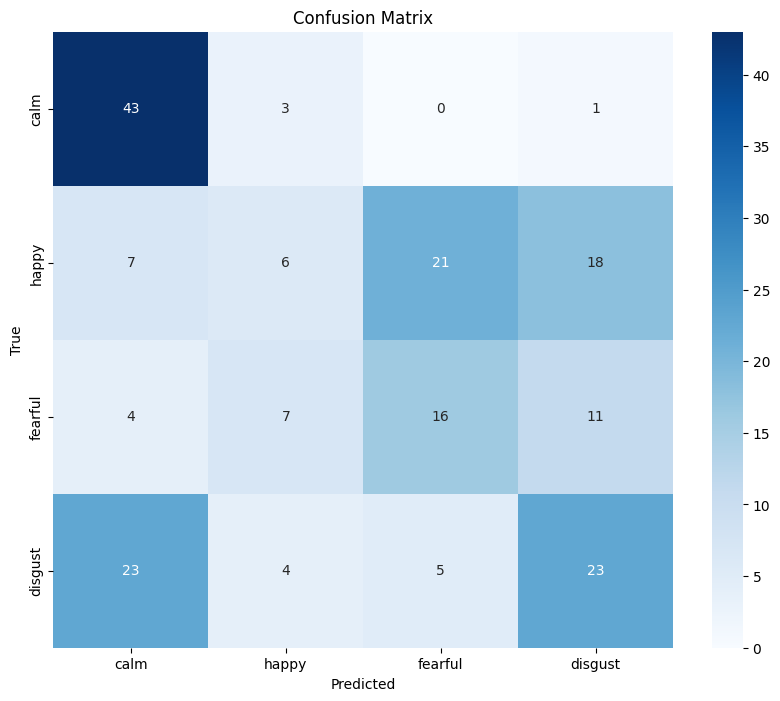

In [13]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=observed_emotions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=observed_emotions, yticklabels=observed_emotions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model, x_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
)

In [15]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

In [16]:
# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

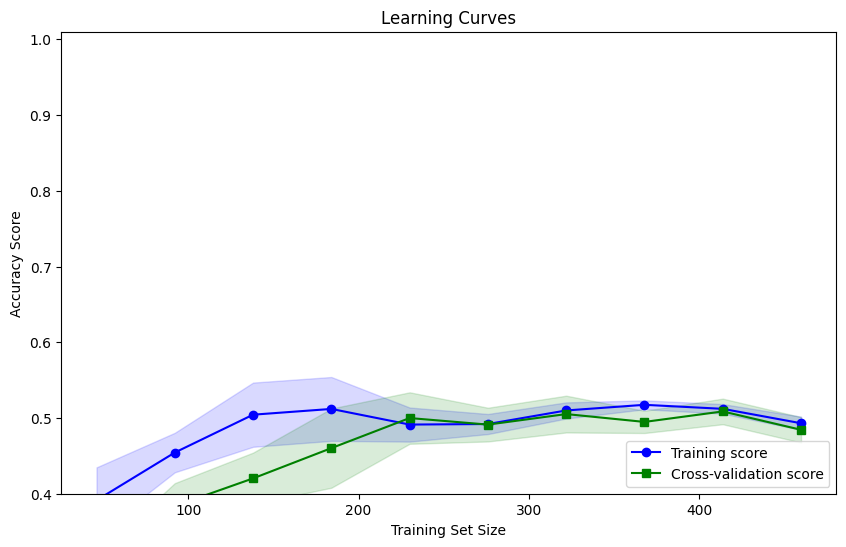

In [17]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="green", marker='s')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="lower right")
plt.ylim([0.4, 1.01])
plt.show()

In [18]:
# Optional: Save the model
joblib.dump(model, 'svm_emotion_model.joblib')
print("Model saved as 'svm_emotion_model.joblib'")

Model saved as 'svm_emotion_model.joblib'
